# Taller 3 - MLFlow
Universidad del Valle de Guatemala, 9 de septiembre de 2025<br>
MLE, Sección 10

**Author(s):**
- Andrea Ximena Ramirez Recinos (21874)
- Adrian Ricardo Flores Trujillo (21500)
- Daniel Armando Valdez Reyes (21240)


# Parte 1 - Viendo la documentación de MLFlow

Las tres páginas/secciones que más útiles:

**1) Evaluación con SHAP** ([https://mlflow.org/docs/latest/ml/evaluation/shap/](https://mlflow.org/docs/latest/ml/evaluation/shap/))
Es interesante porque baja la interpretabilidad a algo práctico: ver “por qué” el modelo decide lo que decide dentro del mismo flujo de MLflow. Sirve para explicar resultados a otros, detectar señales raras (fugas, outliers) y justificar decisiones sin ponerse demasiado técnico.

**2) Team collaboration**
(Tracking setup, Running MLflow anywhere, Auth, Projects)
Este bloque es clave para pasar de “mi cuaderno” a “trabajo en equipo”. *Tracking setup* ayuda a estandarizar cómo registramos cosas; *Running anywhere* te deja acomodarte a la infraestructura que tengas (local o nube) sin drama; *Auth* pone orden con accesos y permisos; y *Projects* da una forma limpia de empaquetar y reproducir experimentos. En conjunto, es lo que hace que el trabajo sea compartible y repetible sin depender de una sola máquina.

**3) Spark ML (traditional ML)** ([https://mlflow.org/docs/latest/ml/traditional-ml/sparkml/](https://mlflow.org/docs/latest/ml/traditional-ml/sparkml/))
Nos llamó la atención como “ruta de crecimiento”. Aunque hoy no usamos Spark, es bueno saber que MLflow ya tiene el puente para cuando los datos crezcan o haya que correr en clúster. Te mantiene el mismo hábito de registrar métricas/modelos, pero en un entorno que escala sin reescribir todo.


# Parte 2 - MLFlow Hacer el tutorial

## Inicialización del cliente de MLflow



In [21]:
from mlflow import MlflowClient

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

#### Buscar experimentos con la API del cliente de MLflow

Veamos el experimento predeterminado que se crea para nosotros.

Este experimento de respaldo (“fallback”) almacenará las ejecuciones (Runs) que creemos si no especificamos un experimento nuevo.


In [22]:
# Search experiments without providing query terms behaves effectively as a 'list' action

all_experiments = client.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1757382835009, experiment_id='0', last_update_time=1757382835009, lifecycle_stage='active', name='Default', tags={}>]


In [23]:
from pprint import pprint

# Extract the experiment name and lifecycle_stage
default_experiment = [
    {"name": experiment.name, "lifecycle_stage": experiment.lifecycle_stage}
    for experiment in all_experiments
    if experiment.name == "Default"
][0]

pprint(default_experiment)

{'lifecycle_stage': 'active', 'name': 'Default'}


### Crear un nuevo experimento

En esta sección vamos a:
* Crear un nuevo experimento de MLflow
* Aplicar metadatos en forma de **etiquetas del experimento**

In [24]:
experiment_description = (
    "This is the grocery forecasting project. "
    "This experiment contains the produce models for apples."
)

experiment_tags = {
    "project_name": "grocery-forecasting",
    "store_dept": "produce",
    "team": "stores-ml",
    "project_quarter": "Q3-2023",
    "mlflow.note.content": experiment_description,
}

produce_apples_experiment = client.create_experiment(name="Apple_Models_V2", tags=experiment_tags)

In [25]:
# Use search_experiments() to search on the project_name tag key

apples_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'grocery-forecasting'"
)

pprint(apples_experiment[0])

<Experiment: artifact_location='mlflow-artifacts:/461911017237617962', creation_time=1757436868886, experiment_id='461911017237617962', last_update_time=1757436868886, lifecycle_stage='active', name='Apple_Models_V2', tags={'mlflow.note.content': 'This is the grocery forecasting project. This '
                        'experiment contains the produce models for apples.',
 'project_name': 'grocery-forecasting',
 'project_quarter': 'Q3-2023',
 'store_dept': 'produce',
 'team': 'stores-ml'}>


In [26]:
# Access individual tag data

print(apples_experiment[0].tags["team"])

stores-ml


### Ejecutar nuestro primer entrenamiento de modelo

En esta sección vamos a:

* crear un conjunto de datos sintético relevante para una tarea simple de pronóstico de demanda
* iniciar una ejecución (Run) de MLflow
* registrar métricas, parámetros y etiquetas en la ejecución
* guardar el modelo dentro de la ejecución
* registrar el modelo durante el proceso de *logging* del modelo


#### Synthetic data generator for demand of apples

Keep in mind that this is purely for demonstration purposes. 

The demand value is purely artificial and is deliberately covariant with the features. This is not a particularly realistic real-world scenario (if it were, we wouldn't need Data Scientists!). 

In [27]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd


def generate_apple_sales_data_with_promo_adjustment(base_demand: int = 1000, n_rows: int = 5000):
    """
    Generates a synthetic dataset for predicting apple sales demand with seasonality and inflation.

    This function creates a pandas DataFrame with features relevant to apple sales.
    The features include date, average_temperature, rainfall, weekend flag, holiday flag,
    promotional flag, price_per_kg, and the previous day's demand. The target variable,
    'demand', is generated based on a combination of these features with some added noise.

    Args:
        base_demand (int, optional): Base demand for apples. Defaults to 1000.
        n_rows (int, optional): Number of rows (days) of data to generate. Defaults to 5000.

    Returns:
        pd.DataFrame: DataFrame with features and target variable for apple sales prediction.

    Example:
        >>> df = generate_apple_sales_data_with_seasonality(base_demand=1200, n_rows=6000)
        >>> df.head()
    """

    # Set seed for reproducibility
    np.random.seed(9999)

    # Create date range
    dates = [datetime.now() - timedelta(days=i) for i in range(n_rows)]
    dates.reverse()

    # Generate features
    df = pd.DataFrame(
        {
            "date": dates,
            "average_temperature": np.random.uniform(10, 35, n_rows),
            "rainfall": np.random.exponential(5, n_rows),
            "weekend": [(date.weekday() >= 5) * 1 for date in dates],
            "holiday": np.random.choice([0, 1], n_rows, p=[0.97, 0.03]),
            "price_per_kg": np.random.uniform(0.5, 3, n_rows),
            "month": [date.month for date in dates],
        }
    )

    # Introduce inflation over time (years)
    df["inflation_multiplier"] = 1 + (df["date"].dt.year - df["date"].dt.year.min()) * 0.03

    # Incorporate seasonality due to apple harvests
    df["harvest_effect"] = np.sin(2 * np.pi * (df["month"] - 3) / 12) + np.sin(
        2 * np.pi * (df["month"] - 9) / 12
    )

    # Modify the price_per_kg based on harvest effect
    df["price_per_kg"] = df["price_per_kg"] - df["harvest_effect"] * 0.5

    # Adjust promo periods to coincide with periods lagging peak harvest by 1 month
    peak_months = [4, 10]  # months following the peak availability
    df["promo"] = np.where(
        df["month"].isin(peak_months),
        1,
        np.random.choice([0, 1], n_rows, p=[0.85, 0.15]),
    )

    # Generate target variable based on features
    base_price_effect = -df["price_per_kg"] * 50
    seasonality_effect = df["harvest_effect"] * 50
    promo_effect = df["promo"] * 200

    df["demand"] = (
        base_demand
        + base_price_effect
        + seasonality_effect
        + promo_effect
        + df["weekend"] * 300
        + np.random.normal(0, 50, n_rows)
    ) * df["inflation_multiplier"]  # adding random noise

    # Add previous day's demand
    df["previous_days_demand"] = df["demand"].shift(1)
    df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row

    # Drop temporary columns
    df.drop(columns=["inflation_multiplier", "harvest_effect", "month"], inplace=True)

    return df

In [28]:
# Generate the dataset!

data = generate_apple_sales_data_with_promo_adjustment(base_demand=1_000, n_rows=1_000)

data[-20:]

C:\Users\danar\AppData\Local\Temp\ipykernel_20336\3503073555.py:83: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row
C:\Users\danar\AppData\Local\Temp\ipykernel_20336\3503073555.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row


,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand
980,2025-08-21 10:54:29.026287,34.130183,1.454065,0,0,1.449177,0,999.306290,1029.418398
981,2025-08-22 10:54:29.026287,32.353643,9.462859,0,0,2.856503,0,842.129427,999.306290
982,2025-08-23 10:54:29.026287,18.816833,0.391470,1,0,1.326429,0,1317.616709,842.129427
983,2025-08-24 10:54:29.026287,34.533012,2.120477,1,0,0.970131,0,1395.802075,1317.616709
984,2025-08-25 10:54:29.026287,23.057202,2.365705,0,0,1.049931,0,1019.486305,1395.802075
985,2025-08-26 10:54:29.026287,34.810165,3.089005,0,0,2.035149,0,1002.564672,1019.486305
986,2025-08-27 10:54:29.026287,29.208905,3.673292,0,0,2.518098,0,1086.143402,1002.564672
987,2025-08-28 10:54:29.026287,16.428676,4.077782,0,0,1.268979,0,1093.207186,1086.143402
988,2025-08-29 10:54:29.026287,32.067512,2.734454,0,0,0.762317,0,1069.939894,1093.207186
989,2025-08-30 10:54:29.026287,31.938203,13.883486,1,0,1.153301,0,1321.409540,1069.939894


#### Análisis del generador de datos sintéticos
A grandes rasgos, el generador está bien armado para una demo: mete calendario, clima básico, fines de semana, feriados, precio, promos y un *lag* de demanda. Si me tocara revisarlo con calma, lo primero que ajustaría sería la reproducibilidad: en vez de `datetime.now()`, fijaría un `start_date` y un `seed` paramétricos. Así cada corrida arranca en el mismo punto del tiempo y los resultados son 100% comparables.

El segundo cambio lo haría en cómo se modela la inflación. Multiplicar la demanda por un factor inflacionario se siente raro; la inflación debería pegarle al **precio**, y luego la demanda responder con una **elasticidad precio** (p. ej., $(precio / precio\_ref)^{\text{elasticidad}}$). Esto evita “inflar” también el ruido y produce series más creíbles: el precio sube con los años y la demanda se ajusta en consecuencia.

También replantearía las promociones. Marcar todo un mes como promo termina en una variable que, en la práctica, es un proxy del mes y se mezcla con la estacionalidad. Prefiero campañas en ráfagas cortas (7–21 días), separadas por descansos breves, o bien alinearlas a la post-cosecha pero en ventanas discretas. Eso obliga al modelo a distinguir entre “temporada” y “empuje comercial”, que es lo que nos interesa.

Por último, amarraría el clima al calendario (temperaturas y lluvias con medias mensuales + ruido) para que exista una estructura estacional plausible, y cuidaría la evaluación: como ya incluimos `previous_days_demand`, el *split* debe ser **temporal** (bloques por fecha) para no filtrar información del futuro al pasado. Con esos retoques, el dataset sigue siendo sencillo, pero el comportamiento que aprende el modelo se parece mucho más a un caso real.


### Entrenar y registrar el modelo

Ya estamos listos para importar nuestra clase de modelo y entrenar un `RandomForestRegressor`.


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import mlflow

# Use the fluent API to set the tracking uri and the active experiment
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment to the "Apple_Models" experiment and returns the Experiment metadata
apple_experiment = mlflow.set_experiment("Apple_Models_V2")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "apples_rf_test"

# Define an artifact path that the model will be saved to.
artifact_path = "rf_apples"

In [31]:
# Split the data into features and target and drop irrelevant date field and target field
X = data.drop(columns=["date", "demand"])
y = data["demand"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    "n_estimators": 100,
    "max_depth": 6,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
    "random_state": 888,
}

# Train the RandomForestRegressor
rf = RandomForestRegressor(**params)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf.predict(X_val)

# Calculate error metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Assemble the metrics we're going to write into a collection
metrics = {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

# Initiate the MLflow run context
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model fit
    mlflow.log_params(params)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(sk_model=rf, input_example=X_val, name=artifact_path)

c:\Users\danar\MLFLOW\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run apples_rf_test at: http://127.0.0.1:8080/#/experiments/461911017237617962/runs/9465ffd23d534a3fa1521c634645d4a3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/461911017237617962


#### Metricas

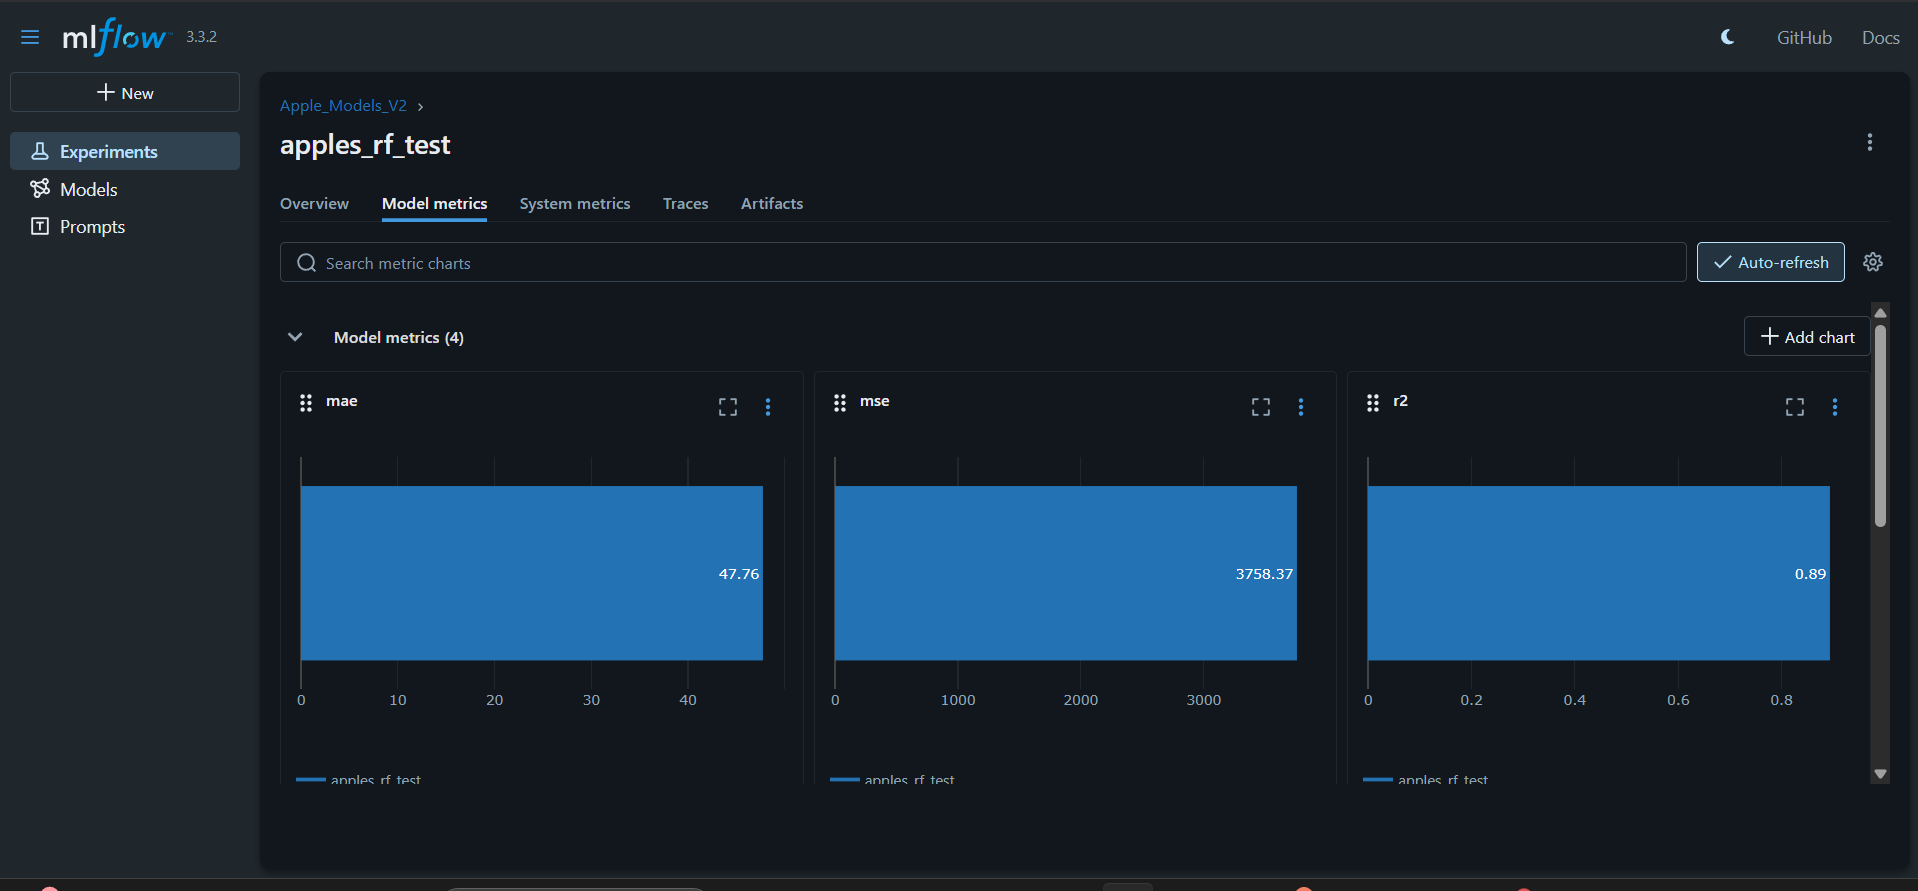


# Parte 3 - Conexión con Pipeline SKLearn

In [33]:
#%pip install sklearn --upgrade

In [43]:
# --- Iris + sklearn Pipeline + MLflow ---
import mlflow
import mlflow.sklearn

import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from mlflow.models import infer_signature

In [ ]:

mlflow.set_experiment("Iris_Pipeline_Demo")

# Cargamos Iris como DataFrame
iris = load_iris(as_frame=True)
df = iris.frame.copy()
X = df.drop(columns=["target"])
y = df["target"]
X.columns = [c.replace(" (cm)", "").replace(" ", "_") for c in X.columns]  # nombres amigables

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline sencillo: escalado + bosque
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42))
])

with mlflow.start_run(run_name="iris_rf_pipeline") as run:
    # Entrenamos
    pipe.fit(X_train, y_train)

    # Predicciones y métricas
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    # Log de params (tomados del estimator dentro del pipeline)
    rf = pipe.named_steps["rf"]
    mlflow.log_params({
        "n_estimators": rf.n_estimators,
        "max_depth": rf.max_depth,
        "random_state": rf.random_state
    })

    # Log de métricas
    mlflow.log_metrics({"accuracy": acc, "f1_macro": f1m})

    # Firma + ejemplo y log del modelo (listo para servir)
    signature = infer_signature(X_train, pipe.predict(X_train))
    mlflow.sklearn.log_model(
        sk_model=pipe,
        artifact_path="model",
        signature=signature,
        input_example=X_train.iloc[:5]
    )

    print("Run ID:", run.info.run_id)
    print("accuracy:", acc, "f1_macro:", f1m)
    print("Model URI:", f"runs:/{run.info.run_id}/model")


2025/09/09 11:23:59 INFO mlflow.tracking.fluent: Experiment with name 'Iris_Pipeline_Demo' does not exist. Creating a new experiment.
2025/09/09 11:23:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Run ID: c8d0a4a063af431e9a14ef7c9df697c7
accuracy: 0.9 f1_macro: 0.899749373433584
Model URI: runs:/c8d0a4a063af431e9a14ef7c9df697c7/model
🏃 View run iris_rf_pipeline at: http://127.0.0.1:8080/#/experiments/310509034068092415/runs/c8d0a4a063af431e9a14ef7c9df697c7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/310509034068092415


### ¿Qué se realizó?
Primero se carga el dataset de **Iris** como DataFrame y se separan las variables de entrada del objetivo. Los nombres de las columnas se limpian para evitar espacios o sufijos innecesarios, de modo que cualquier registro o despliegue posterior sea más sencillo y consistente. Luego se realiza un **train/test split** con parámetros fijos para mantener la reproducibilidad de los resultados.

El núcleo del flujo es un **Pipeline de scikit-learn** con dos etapas: `StandardScaler` para estandarizar las features y `RandomForestClassifier` como modelo. Esto asegura que el preprocesamiento quede acoplado al estimador: lo que se aprende en entrenamiento es exactamente lo que se aplicará en inferencia, evitando fugas y diferencias entre ambientes.

Con **MLflow**, se define el experimento (`Iris_Pipeline_Demo`) y se inicia un run (`iris_rf_pipeline`). Dentro de ese run se entrena el pipeline, se generan predicciones sobre el conjunto de prueba y se registran métricas clave como **accuracy** y **F1 macro**. También se registran parámetros relevantes del modelo (por ejemplo, `n_estimators` y `max_depth`) para poder comparar corridas y entender por qué cambian los resultados.

Finalmente, se guarda el **modelo como artefacto de MLflow**, incluyendo la **signature** (el esquema de entrada y salida) y un **input example** para validar el contrato del modelo al servirlo o recargarlo. Con eso, la **UI de MLflow** muestra el histórico completo del experimento —parámetros, métricas y artefactos— y deja el camino listo para, si se desea, registrar el modelo en un **Model Registry** y promoverlo entre *staging* y *production* sin tocar el código del pipeline.



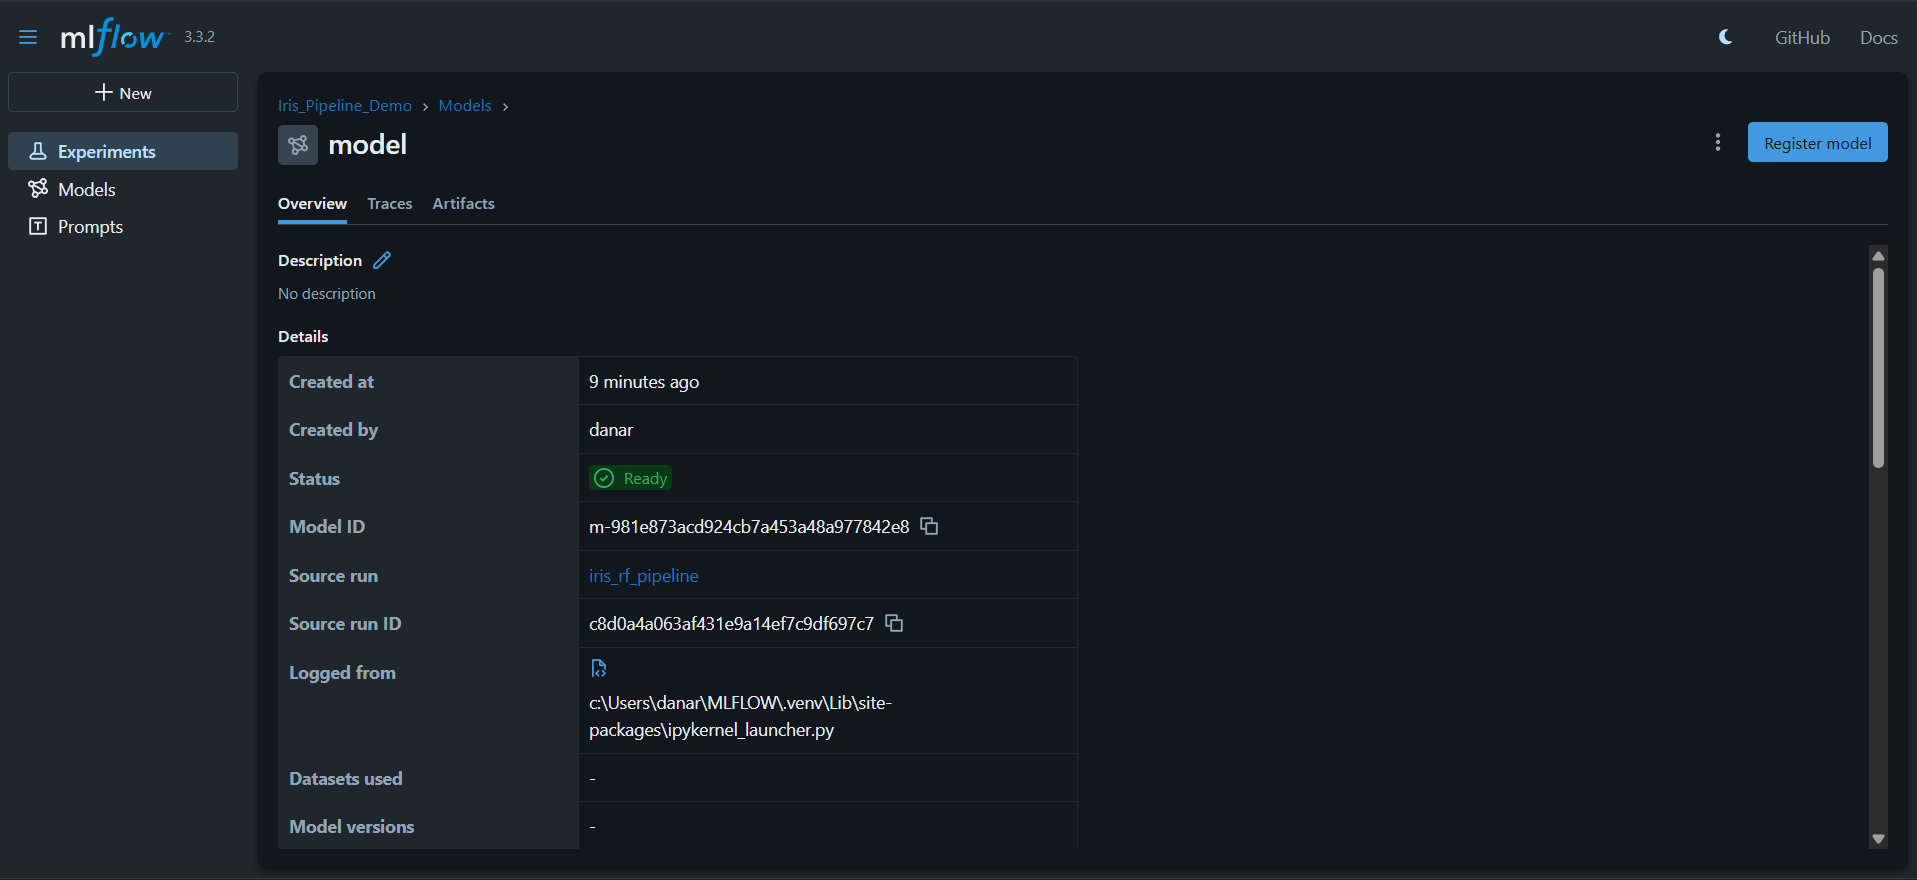